In [56]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [57]:
df = pd.read_csv("datos/bikes_stand.csv", index_col=0)
df.head(5)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,registered
0,2018-01-01,winter,0,1,1,Monday,0,2,-0.486274,0.855582,-0.208909,654
1,2018-01-02,winter,0,1,0,Tuesday,1,2,-0.425690,0.332722,0.687550,670
2,2018-01-03,winter,0,1,0,Wednesday,1,1,-0.949970,-0.900337,0.685210,1229
3,2018-01-04,winter,0,1,0,Thursday,1,1,-0.938563,-0.170632,-0.210435,1454
4,2018-01-05,winter,0,1,0,Friday,1,1,-0.853992,-0.901843,0.060294,1518


In [58]:
lista_categoricas = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

In [59]:
df_season = df.groupby('season')["registered"].median().reset_index().sort_values(by = "registered")
df_season

,season,registered
3,winter,1869.0
0,autumn,3815.0
1,spring,3844.0
2,summer,4110.5


In [60]:
print(f'winter: 1')
print(f'autumn: {df_season.loc[0, "registered"]/df_season.loc[3, "registered"]}')
print(f'spring: {df_season.loc[1, "registered"]/df_season.loc[3, "registered"]}')
print(f'summer: {df_season.loc[2, "registered"]/df_season.loc[3, "registered"]}')

winter: 1
autumn: 2.041198501872659
spring: 2.0567148207597645
summer: 2.1993044408774747


In [61]:
df_yr = df.groupby('yr')["registered"].median().reset_index().sort_values(by = "registered")
df_yr

,yr,registered
0,0,2915.0
1,1,4790.0


In [62]:
print(f'0: 1')
print(f'1: {df_yr.loc[1, "registered"]/df_yr.loc[0, "registered"]}')

0: 1
1: 1.6432246998284734


In [63]:
df_mnth = df.groupby('mnth')["registered"].median().reset_index().sort_values(by = "registered")
df_mnth

,mnth,registered
0,1,1657.5
1,2,2024.0
2,3,2347.0
11,12,3155.0
3,4,3395.5
10,11,3746.5
4,5,3883.5
6,7,4005.5
9,10,4014.0
7,8,4116.5


In [64]:
print(f'1: 1')
print(f'2: {df_mnth.loc[1, "registered"]/df_mnth.loc[0, "registered"]}')
print(f'3: {df_mnth.loc[2, "registered"]/df_mnth.loc[0, "registered"]}')
print(f'4: {df_mnth.loc[3, "registered"]/df_mnth.loc[0, "registered"]}')
print(f'5: {df_mnth.loc[4, "registered"]/df_mnth.loc[0, "registered"]}')
print(f'6: {df_mnth.loc[5, "registered"]/df_mnth.loc[0, "registered"]}')
print(f'7: {df_mnth.loc[6, "registered"]/df_mnth.loc[0, "registered"]}')
print(f'8: {df_mnth.loc[7, "registered"]/df_mnth.loc[0, "registered"]}')
print(f'9: {df_mnth.loc[8, "registered"]/df_mnth.loc[0, "registered"]}')
print(f'10: {df_mnth.loc[9, "registered"]/df_mnth.loc[0, "registered"]}')
print(f'11: {df_mnth.loc[10, "registered"]/df_mnth.loc[0, "registered"]}')
print(f'12: {df_mnth.loc[11, "registered"]/df_mnth.loc[0, "registered"]}')

1: 1
2: 1.2211161387631977
3: 1.4159879336349925
4: 2.0485671191553543
5: 2.3429864253393666
6: 2.629864253393665
7: 2.4165912518853694
8: 2.483559577677225
9: 2.5110105580693816
10: 2.4217194570135745
11: 2.2603318250377074
12: 1.903469079939668


In [65]:
df_holiday = df.groupby('holiday')["registered"].median().reset_index().sort_values(by = "registered")
df_holiday

,holiday,registered
1,1,2653.0
0,0,3694.5


In [66]:
print(f'1: 1')
print(f'0: {df_holiday.loc[0, "registered"]/df_holiday.loc[1, "registered"]}')

1: 1
0: 1.3925744440256314


In [67]:
df_weekday = df.groupby('weekday')["registered"].median().reset_index().sort_values(by = "registered")
df_weekday

,weekday,registered
5,Tuesday,2932.0
1,Monday,3077.0
6,Wednesday,3700.0
3,Sunday,3715.5
2,Saturday,3834.5
0,Friday,3963.5
4,Thursday,4052.5


In [68]:
print(f'Monday: 1')
print(f'Tuesday: {df_weekday.loc[5, "registered"]/df_weekday.loc[1, "registered"]}')
print(f'Sunday	: {df_weekday.loc[3, "registered"]/df_weekday.loc[1, "registered"]}')
print(f'Wednesday: {df_weekday.loc[6, "registered"]/df_weekday.loc[1, "registered"]}')
print(f'Saturday: {df_weekday.loc[2, "registered"]/df_weekday.loc[1, "registered"]}')
print(f'Friday: {df_weekday.loc[0, "registered"]/df_weekday.loc[1, "registered"]}')
print(f'Thursday: {df_weekday.loc[4, "registered"]/df_weekday.loc[1, "registered"]}')

Monday: 1
Tuesday: 0.9528761780955476
Sunday	: 1.207507312317192
Wednesday: 1.2024699382515438
Saturday: 1.2461813454663633
Friday: 1.2881052973675657
Thursday: 1.3170295742606435


In [69]:
df_weathersit = df.groupby('weathersit')["registered"].median().reset_index().sort_values(by = "registered")
df_weathersit

,weathersit,registered
2,3,1672.0
1,2,3354.0
0,1,3875.0


In [70]:
print(f'3: 1')
print(f'2: {df_weathersit.loc[1, "registered"]/df_weathersit.loc[2, "registered"]}')
print(f'1: {df_weathersit.loc[0, "registered"]/df_weathersit.loc[2, "registered"]}')

3: 1
2: 2.0059808612440193
1: 2.3175837320574164


In [71]:
df_workingday = df.groupby('workingday')["registered"].median().reset_index().sort_values(by = "registered")
df_workingday

,workingday,registered
1,1,3633.0
0,0,3720.5


In [72]:
print(f'0: 1')
print(f'1: {df_workingday.loc[1, "registered"]/df_workingday.loc[0, "registered"]}')

0: 1
1: 0.9764816556914393


In [73]:
df["season_encoding"] = df["season"].map({"winter": 1, "autumn": 2.041, "spring": 2.057, "summer": 2.199})
df['yr_encoding'] = df['yr'].map({0:1, 1:1.643})
df['mnth_encoding'] = df['mnth'].map({1:1, 2: 1.221, 3: 1.416, 4:2.049, 5:2.343, 6:2.630, 7:2.417, 8:2.484, 9:2.511, 10:2.421, 11:2.260, 12:1.903 })
df['holiday_encoding'] = df['holiday'].map({0:1.393, 1:1})
df['weekday_encoding'] = df['weekday'].map({'Monday':1, 'Tuesday':0.953, 'Wednesday':1.202, 'Thursday':1.317, 'Friday':1.288, 'Saturday':1.246, 'Sunday':1.208})
df['weathersit_encoding'] = df['weathersit'].map({1:2.318, 2:2.006, 3:1})
df['workingday_encoding'] = df['workingday'].map({0:1, 1:1.019})

In [74]:
# oh = OneHotEncoder()
# transformados_wd = oh.fit_transform(df[["workingday"]])
# oh_df = pd.DataFrame(transformados_wd.toarray())
# oh_df.columns = oh.get_feature_names_out()
# df = pd.concat([df,oh_df],axis=1)

In [75]:
df.drop(columns=['dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit'], inplace=True)

In [76]:
X = df.drop("registered", axis = 1)
y = df["registered"]

In [77]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 23)

In [78]:
arbol = DecisionTreeRegressor(random_state = 23)

arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=23)

In [79]:
max_features = np.sqrt(len(x_train.columns))
max_features

3.1622776601683795

In [80]:
print(arbol.tree_.max_depth)

19


In [81]:
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [82]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [83]:
dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decision Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,518.164384,565381.082192,751.918268,0.725957,test,Decision Tree I
1,0.000000,0.000000,0.000000,1.000000,train,Decision Tree I


In [84]:
param = {"max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10], 
        "max_features": [2,3,4,5, 6],
        "min_samples_split": [10, 20, 30, 50, 150, 200],
        "min_samples_leaf": [10, 20, 30, 50, 150, 200]} 

In [85]:
gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param, 
            cv=10, 
            verbose=-1, 
            return_train_score = True, 
            scoring="neg_mean_squared_error") 

In [86]:
gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [2, 3, 4, 5, 6],
                         'min_samples_leaf': [10, 20, 30, 50, 150, 200],
                         'min_samples_split': [10, 20, 30, 50, 150, 200]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [87]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=10, max_features=6, min_samples_leaf=10,
                      min_samples_split=20)

In [88]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

In [89]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,518.192902,483913.566925,695.638963,0.765445,test,Decision tree II
1,438.310388,376125.991548,613.291115,0.849788,train,Decision tree II


In [90]:
df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,518.164384,565381.082192,751.918268,0.725957,test,Decision Tree I
1,0.000000,0.000000,0.000000,1.000000,train,Decision Tree I
0,518.192902,483913.566925,695.638963,0.765445,test,Decision tree II
1,438.310388,376125.991548,613.291115,0.849788,train,Decision tree II


In [91]:
param2 = {"max_depth": [ 5, 6, 7, 8], 
        "max_features": [1,2,3,4,5,6],
        "min_samples_split": [5, 10, 20, 50, 70],
        "min_samples_leaf": [5, 10, 20, 30]} 

In [92]:
gs2 = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param2, 
            cv=10, 
            verbose=-1, 
            return_train_score = True, 
            scoring="neg_mean_squared_error") 

In [93]:
gs2.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [5, 6, 7, 8],
                         'max_features': [1, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [5, 10, 20, 30],
                         'min_samples_split': [5, 10, 20, 50, 70]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [94]:
mejor_modelo2 = gs2.best_estimator_
mejor_modelo2

DecisionTreeRegressor(max_depth=8, max_features=6, min_samples_leaf=5,
                      min_samples_split=20)

In [95]:
y_pred_test_dt3 = mejor_modelo2.predict(x_test)
y_pred_train_dt3 = mejor_modelo2.predict(x_train)

In [96]:
dt_results3 = metricas(y_test, y_train, y_pred_test_dt3, y_pred_train_dt3, "Decision tree III")
dt_results3

,MAE,MSE,RMSE,R2,set,modelo
0,604.559063,693097.051677,832.524505,0.664053,test,Decision tree III
1,397.484206,320788.899055,566.382291,0.871888,train,Decision tree III


In [97]:
df_decision_results = pd.concat([df_decision_results, dt_results3], axis = 0)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,518.164384,565381.082192,751.918268,0.725957,test,Decision Tree I
1,0.000000,0.000000,0.000000,1.000000,train,Decision Tree I
0,518.192902,483913.566925,695.638963,0.765445,test,Decision tree II
1,438.310388,376125.991548,613.291115,0.849788,train,Decision tree II
0,604.559063,693097.051677,832.524505,0.664053,test,Decision tree III
1,397.484206,320788.899055,566.382291,0.871888,train,Decision tree III


In [98]:
bosque = RandomForestRegressor(max_depth=10, max_features=5, min_samples_leaf=10,
                      min_samples_split=10, random_state = 23)
bosque.fit(x_train, y_train)

RandomForestRegressor(max_depth=10, max_features=5, min_samples_leaf=10,
                      min_samples_split=10, random_state=23)

In [99]:
y_pred_test_rf = bosque.predict(x_test)
y_pred_train_rf = bosque.predict(x_train)

In [100]:
rf_results = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Random Forest")
rf_results

,MAE,MSE,RMSE,R2,set,modelo
0,492.649508,411851.364360,641.756468,0.800374,test,Random Forest
1,450.923929,381702.802089,617.821011,0.847561,train,Random Forest


In [101]:
param_rf = {"n_estimators": [100, 250,500],
        "max_depth": [ 5, 6, 7, 8], 
        "max_features": [2,3,4,5,6],
        "min_samples_split": [5, 10, 20, 50, 70],
        "min_samples_leaf": [5, 10, 20, 30]} 

In [102]:
gs_rf = GridSearchCV(
            estimator=RandomForestRegressor(), 
            param_grid= param_rf, 
            cv=10, 
            verbose=-1, 
            return_train_score = True, 
            scoring="neg_mean_squared_error") 

In [103]:
gs_rf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 6, 7, 8],
                         'max_features': [2, 3, 4, 5, 6],
                         'min_samples_leaf': [5, 10, 20, 30],
                         'min_samples_split': [5, 10, 20, 50, 70],
                         'n_estimators': [100, 250, 500]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [104]:
bosque2 = gs_rf.best_estimator_
bosque2

RandomForestRegressor(max_depth=8, max_features=6, min_samples_leaf=5,
                      min_samples_split=5)

In [105]:
y_pred_test_rf2 = bosque2.predict(x_test)
y_pred_train_rf2 = bosque2.predict(x_train)

In [106]:
dt_results_rf2 = metricas(y_test, y_train, y_pred_test_rf2, y_pred_train_rf2, "Random Forest II")
dt_results_rf2

,MAE,MSE,RMSE,R2,set,modelo
0,442.468502,338305.990826,581.640775,0.836022,test,Random Forest II
1,344.189027,243440.540078,493.396940,0.902778,train,Random Forest II


In [107]:
results = pd.concat([df_decision_results, rf_results, dt_results_rf2], axis = 0)
results

,MAE,MSE,RMSE,R2,set,modelo
0,518.164384,565381.082192,751.918268,0.725957,test,Decision Tree I
1,0.000000,0.000000,0.000000,1.000000,train,Decision Tree I
0,518.192902,483913.566925,695.638963,0.765445,test,Decision tree II
1,438.310388,376125.991548,613.291115,0.849788,train,Decision tree II
0,604.559063,693097.051677,832.524505,0.664053,test,Decision tree III
1,397.484206,320788.899055,566.382291,0.871888,train,Decision tree III
0,492.649508,411851.364360,641.756468,0.800374,test,Random Forest
1,450.923929,381702.802089,617.821011,0.847561,train,Random Forest
0,442.468502,338305.990826,581.640775,0.836022,test,Random Forest II
1,344.189027,243440.540078,493.396940,0.902778,train,Random Forest II


In [108]:

# vamos a crearnos un dataframe 
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': bosque2.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores


Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
4,yr_encoding,0.380207
0,temp,0.244394
3,season_encoding,0.115759
5,mnth_encoding,0.111288
1,hum,0.054603
7,weekday_encoding,0.051666
2,windspeed,0.028189
8,weathersit_encoding,0.010078
9,workingday_encoding,0.003741
6,holiday_encoding,0.000074


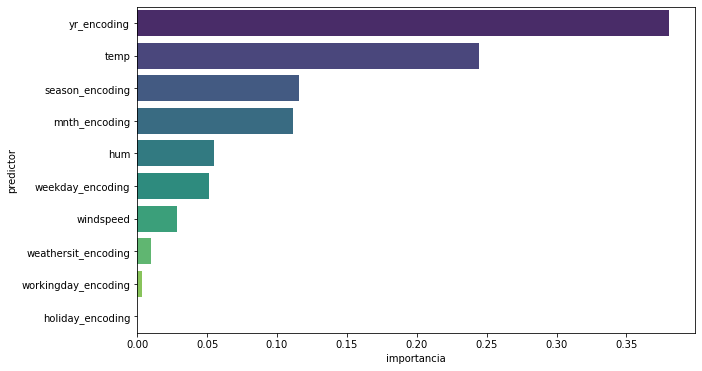

In [109]:
plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()

In [110]:
df_numericas = df.select_dtypes(include = np.number )

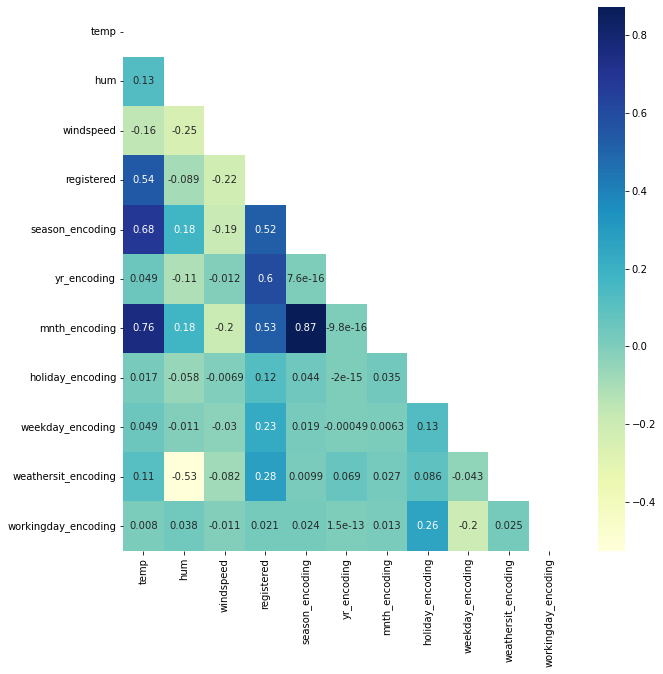

In [111]:
plt.figure(figsize= (10,10)) 
mask = np.triu(np.ones_like(df_numericas.corr(), dtype=np.bool_))
sns.heatmap(df_numericas.corr(),
            cmap = "YlGnBu", 
            mask = mask, # incorporamos la máscara en nuestro plot
           annot = True);